# Imports

In [ ]:
#Main File

# %tensorflow_version 2.x
import keras
from keras import backend
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
from keras.layers import Input, Flatten, Dense, Dropout
from keras.models import Model

from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import os
import glob2 as glob

import numpy as np
from numpy import expand_dims
import matplotlib.pyplot as plt
print(keras.__version__)

from __future__ import print_function
import time

from scipy.optimize import fmin_l_bfgs_b

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

2.5.0
Instructions for updating:
non-resource variables are not supported in the long term


# Constants

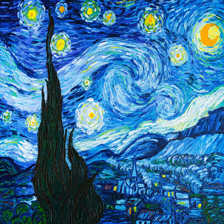

In [ ]:
height = 224
width = 224

content_image_path = 'Content Image Path'
content_image = Image.open(content_image_path)
content_image = content_image.resize((height, width))
content_image

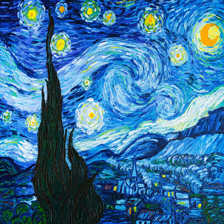

In [ ]:
style_image_path = 'Style Image Path'
style_image = Image.open (style_image_path)
style_image = style_image.resize((height, width))
style_image

In [ ]:
content_array = np.asarray(content_image, dtype='float32')
content_array = np.expand_dims(content_array, axis=0)
print(content_array.shape)

style_array = np.asarray(style_image, dtype='float32')
style_array = np.expand_dims(style_array, axis=0)
print(style_array.shape)

(1, 224, 224, 3)
(1, 224, 224, 3)


In [ ]:
content_array[:,:,:,0] -= 103.99
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array = content_array[:, :, :, ::-1]

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array = style_array[:, :, :, ::-1]

In [ ]:
content_image = backend.variable(content_array)
style_image = backend.variable(style_array)
combination_image = backend.placeholder((1, height, width, 3))

In [ ]:
input_tensor = backend.concatenate([content_image,
                                    style_image,
                                    combination_image], axis = 0)

In [ ]:
model = VGG16(input_tensor=input_tensor, weights='imagenet',
              include_top=False)
layers = dict([(layer.name, layer.output) for layer in model.layers])
layers

{'input_34': <tf.Tensor 'concat_33:0' shape=(3, 224, 224, 3) dtype=float32>,
 'block1_conv1': <tf.Tensor 'block1_conv1_33/Relu:0' shape=(3, 224, 224, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2_33/Relu:0' shape=(3, 224, 224, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool_33/MaxPool:0' shape=(3, 112, 112, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1_33/Relu:0' shape=(3, 112, 112, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2_33/Relu:0' shape=(3, 112, 112, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool_33/MaxPool:0' shape=(3, 56, 56, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1_33/Relu:0' shape=(3, 56, 56, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2_33/Relu:0' shape=(3, 56, 56, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3_33/Relu:0' shape=(3, 56, 56, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool_33/MaxPool:0' shape=(3, 28, 28, 256) dtype=flo

In [ ]:
style_weight = 1.0
content_weight = 1.0

total_variation_weight = 1.0 #if 0, pixel values that are different. if big, lot of smooth
loss = backend.variable(0.)

## Define loss function

### Loss parameters

In [ ]:
def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

layer_features = layers['block2_conv2']
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss = loss + (content_weight * content_loss(content_image_features,
                                      combination_features))

### Style loss (gram matrices)

In [ ]:

def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

def style_loss(gm, combination):
    S = gm
    C = gram_matrix(combination)
    channels = 3
    size = height * width
    return backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))


style_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']
average_excite_gms = np.load("/.../excite.npz", allow_pickle=True)['arr_0']
average_sad_gms = np.load("/.../sad.npz", allow_pickle=True)['arr_0']
average_disgust_gms = np.load("/.../disgust.npz", allow_pickle=True)['arr_0']
for i, layer_name in enumerate(style_layers):
    layer_features = layers[layer_name]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(backend.constant(average_excite_gms[i]), combination_features)
    loss = loss + ((style_weight / len(style_layers)) * sl)

### Total variation loss (smoothness)

In [ ]:
# smooth out image by preventing sharp transitions between pixels
def total_variation_loss(x):
    a = backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))


loss = loss + (total_variation_weight * total_variation_loss(combination_image))

## Compute gradients

In [ ]:
grads = backend.gradients(loss, combination_image)

## Evaluator

In [ ]:
outputs = [loss]
outputs += grads
f_outputs = backend.function([combination_image], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

## Perform gradient descent

In [ ]:
#x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

content_image_path = '/Users/evanb/Downloads/Street.jpg'
content_image = Image.open(content_image_path)
content_image = content_image.resize((height, width))
content_image

content_array = np.asarray(content_image, dtype='float32')
content_array = np.expand_dims(content_array, axis=0)
x = content_array


iterations = 8

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 581819560000.0
Iteration 0 completed in 22s
Start of iteration 1
Current loss value: 355190080000.0
Iteration 1 completed in 20s
Start of iteration 2
Current loss value: 295946700000.0
Iteration 2 completed in 20s
Start of iteration 3
Current loss value: 270286830000.0
Iteration 3 completed in 20s
Start of iteration 4
Current loss value: 257705790000.0
Iteration 4 completed in 20s
Start of iteration 5
Current loss value: 250451940000.0
Iteration 5 completed in 20s
Start of iteration 6
Current loss value: 246818950000.0
Iteration 6 completed in 20s
Start of iteration 7
Current loss value: 244824400000.0
Iteration 7 completed in 20s


## Display generated image

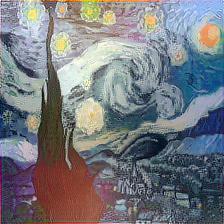

In [ ]:
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

im = Image.fromarray(x)
display(im)

## Save generated image to file

In [ ]:
im.save("gen.jpg")